# Analisi dati Opencoesione

Esecuzione di analisi della banca dati Opencoesione circa i progetti relativi al ciclo di programmazione 2014/2020 aventi come tema sintetico quello della *Ricerca ed innovazione".

## Gruppo di lavoro:

* Lanciotti Antonio
* Di Gaetano Anna
* Olivieri Davide
* D'Agostino Lorenzo

### Target: Regione Marche
Andranno individuati i progetti che ricadono nelle aree tematiche della S3 regionale e di Impresa 4.0 (*leggere [README](https://github.com/LorenzoDag/Economia#readme)*)

### Import librerie ed inizializzazione sessione

In [279]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace # Bisogna sostituire le ',' con '.' nei numeri altrimenti il casting fallisce
from pyspark.sql.types import DoubleType
spark = SparkSession.builder.appName("Economia").getOrCreate()

### Custom schema

### Upload dataset
**Nota**: Cambiare i path

In [280]:
path_localizzazioni = "hdfs://localhost:9000/localizzazioni.csv"
path_progetti = "hdfs://localhost:9000/progetti.csv"
path_soggetti = "hdfs://localhost:9000/soggetti.csv"

localizzazioni = spark.read.option("delimiter", ";").option("header", True).csv(path_localizzazioni)
localizzazioni.createOrReplaceTempView("localizzazioni") # Rende la tabella visibile a spark (per query)
progetti = spark.read.option("delimiter", ";").option("header", True).csv(path_progetti)
progetti = progetti.withColumn("FINANZ_TOTALE_PUBBLICO", regexp_replace("FINANZ_TOTALE_PUBBLICO", ",", "."))
progetti = progetti.withColumn("FINANZ_TOTALE_PUBBLICO", progetti["FINANZ_TOTALE_PUBBLICO"].cast(DoubleType())).fillna(0, subset=["FINANZ_TOTALE_PUBBLICO"])
progetti.createOrReplaceTempView("progetti")             # Rende la tabella visibile a spark (per query)
soggetti = spark.read.option("delimiter", ";").option("header", True).csv(path_soggetti)
soggetti.createOrReplaceTempView("soggetti")             # Rende la tabella visibile a spark (per query)

### Definizione e consecutiva esecuzione query
Seleziona le colonne descritte nel [README](https://github.com/LorenzoDag/Economia#readme) ed esegue una join on *COD_LOCALE_PROGETTO*

In [281]:
select_loc = "localizzazioni.COD_LOCALE_PROGETTO, localizzazioni.DEN_REGIONE, localizzazioni.DEN_PROVINCIA, localizzazioni.DEN_COMUNE, localizzazioni.INDIRIZZO_PROG"
select_prog = "progetti.OC_TITOLO_PROGETTO, progetti.OC_SINTESI_PROGETTO, progetti.DESCRIZIONE_GRANDE_PROGETTO, progetti.CUP_DESCR_CATEGORIA, progetti.CUP_DESCR_NATURA,progetti.CUP_DESCR_TIPOLOGIA,progetti.CUP_DESCR_SETTORE,progetti.CUP_DESCR_SOTTOSETTORE,progetti.OC_DATA_INIZIO_PROGETTO,progetti.FINANZ_TOTALE_PUBBLICO"
select_sogg = "soggetti.COD_ATECO_SOGG, soggetti.SOGG_DESCR_RUOLO, soggetti.OC_CODICE_FISCALE_SOGG, soggetti.OC_DENOMINAZIONE_SOGG, soggetti.INDIRIZZO_SOGG, soggetti.CAP_SOGG"

where_prog = "progetti.OC_COD_CICLO = 2 AND progetti.OC_COD_TEMA_SINTETICO = 1"
where_loc = "LOWER(localizzazioni.DEN_REGIONE) LIKE '%marche%'"

QUERY = "SELECT " + select_loc + ", " + select_prog + ", " + select_sogg + " FROM localizzazioni INNER JOIN progetti ON localizzazioni.COD_LOCALE_PROGETTO = progetti.COD_LOCALE_PROGETTO INNER JOIN soggetti ON localizzazioni.COD_LOCALE_PROGETTO = soggetti.COD_LOCALE_PROGETTO WHERE " + where_loc + " AND " + where_prog

In [282]:
result_dataframe = spark.sql(QUERY)
result_dataframe.createOrReplaceTempView("result")
spark.catalog.cacheTable("result")

### Definizione funzione filtro
input: 
> * dataframe_name : (String) nome della tabella cachata
> * testo : (String / List of string) testo da filtrare all'interno della tabella

output:
> * None : se testo vuoto
> * dataframe filtrato : (pyspark.sql.dataframe.DataFrame) dataframe contenente le righe che contengono testo

In [283]:
from functools import reduce
from pyspark.sql import DataFrame

def filterDataframeForKeyword(dataframe_name, testo=''):
    if not testo: return None
    if not isinstance(testo, list):
        testo = testo.lower()
        return spark.sql(f"SELECT * FROM {dataframe_name} WHERE LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{testo}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{testo}%'")
    df_list = []
    for word in testo:
        df_list.append(spark.sql(f"SELECT * FROM {dataframe_name} WHERE LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{word}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{word}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{word}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{word}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{word}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{word}%'"))
    return reduce(DataFrame.unionAll, df_list)

# Filtraggio del dataframe
L'obiettivo e' quello di filtrare le righe del dataframe contenenti parole chiave riconducibili a progetti inerenti le dimensioni tematiche descritte nel file [README](https://github.com/LorenzoDag/Economia#readme) ed i progetti di **industria 4.0**

### Definizione parole chiave

In [284]:
s3_dict = {
    "s3_1": ["industria intelligente", "ambiente", "industria sostenibile", "energia rinnovabile", "energie rinnovabili", "rinnovabili", "ecocompatibili", "generazione distribuita", "biomateriali", "sostenibilità ambientale", "bonifiche di siti contaminati", "bonifica"],
    "s3_2": ["salute", "alimentazione", "healthy ageing", "e-healty", "healty", "assistenza domiciliare", "medicina rigenerativa", "diagnostica avanzata", "diagnostica", "bioinformatica", "sviluppo farmaceutico", "agricoltura di precisione", "agricoltura del futuro", "agricoltura avanzata", "packaging", "tracciabilità", "produzioni alimentari", "nutraceutica", "nutrigenomica", "alimenti funzionali"],
    "s3_3": ["agenda digitale", "smart communities", "mobilità intelligente", "logistica", "mobilità urbana", "sicurezza dell’ambiente urbano", "monitoraggio ambientale", "prevenzione di eventi critici", "reti di sensori intelligenti", "sensori intelligenti", "smart building", "efficientamento energetico", "web economy"],
    "s3_4": ["turismo", "patrimonio culturale", "applicazioni per il turismo", "made in italy", "culturali", "artistici", "paesaggistici", "artigianato digitale", "gaming", "editoria digitale"],
    "s3_5": ["aerospazio", "difesa", "green engine", "avionica avanzata", "air traffic", "unmanned aerial veicle", "ultra-Léger Motorisé", "avionica", "robotica spaziale", "interfaccia uomo-macchina", "propulsione elettrica", "cantieristica militare"],
}

ind4_dict = {
    "manufacturing": ["robot collaborativi", "collaborativi", "3d", "stampa 3d", "robot programmabili", "robot interconnessi"],
    "augmented_reality": ["realtà aumentata", "augmented reality"],
    "simulation": ["simulazione tra macchine", "simulazioni tra macchine"],
    "integration": ["integrazione verticale", "integrazione orizzontale", "integrazione dati"],
    "iot": ["internet of things", "iot"],
    "cloud": ["cloud computing", "cloud", "elevate quantità di dati"],
    "cybercecurity": ["cybersecurity", "sicurezza informatica", "sistemi aperti"],
    "analytics": ["big data", "analytics", "analisi di base dati", "analisi di database", "analisi di dati", "analisi dei dati"],
}

### Filtraggio del dataframe

In [285]:
s3_df = filterDataframeForKeyword("result", reduce(lambda a,b: a+b, s3_dict.values()))    # Contiene le righe inerenti le aree tematiche di tipo s3
ind4_df = filterDataframeForKeyword("result", reduce(lambda a,b: a+b, ind4_dict.values())) # Contiene le riche inerenti i progetti di industria 4.0

In [286]:
s3_df_dict = {}
ind4_df_dict = {} # Dizionario contenente i dataframe filtrati per parole chiave 
for key, value in s3_dict.items():
    s3_df_dict[key] = filterDataframeForKeyword("result", value)
for key, value in ind4_dict.items():
    ind4_df_dict[key] = filterDataframeForKeyword("result", value)

### Filtraggio dei duplicati dove il progetto e' assegnato alla stessa azienda

Questo perche' all'interno del dataframe il progetto appare piu' volte se l'azienda appare sia come beneficiario del progetto che come attuatore dello stesso.

In [298]:
s3_df_nodup = s3_df.dropDuplicates(["COD_LOCALE_PROGETTO", "OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
s3_df_nodup.createOrReplaceTempView("s3")
spark.catalog.cacheTable("s3")
ind4_df_nodup = ind4_df.dropDuplicates(["COD_LOCALE_PROGETTO", "OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
ind4_df_nodup.createOrReplaceTempView("ind4")
spark.catalog.cacheTable("ind4")

for s3_key in s3_dict.keys() :
    s3_df_dict[s3_key] = s3_df_dict[s3_key].dropDuplicates(["OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
    s3_df_dict[s3_key].createOrReplaceTempView(s3_key)
    spark.catalog.cacheTable(s3_key)
    
for ind4_key in ind4_dict.keys():
    ind4_df_dict[ind4_key] = ind4_df_dict[ind4_key].dropDuplicates(["OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
    ind4_df_dict[ind4_key].createOrReplaceTempView(ind4_key)
    spark.catalog.cacheTable(ind4_key)

### Stampa dimensioni datasets
*Nota*: Se viene eseguito lo snippet precedente il numero di righe sara' inferiore

In [288]:
print("DATASET AREE TEMATICHE S3:\n")
for key, val in s3_df_dict.items():
    print(f"\t{key}: count = {val.count()}")
    
print("\nDATASET INDUSTRIA 4.0:\n")
for key, val in ind4_df_dict.items():
    print(f"\t{key}: count = {val.count()}")

DATASET AREE TEMATICHE S3:

	s3_1: count = 42
	s3_2: count = 120
	s3_3: count = 19
	s3_4: count = 0
	s3_5: count = 0

DATASET INDUSTRIA 4.0:

	manufacturing: count = 0
	augmented_reality: count = 0
	simulation: count = 0
	integration: count = 0
	iot: count = 69
	cloud: count = 3
	cybercecurity: count = 0
	analytics: count = 0


# Visualizzazione
Visualizzazione dei risultati ottenuti dal filtraggio dei dati di Opencoesione.

In [289]:
import sys
!{sys.executable} -m pip install matplotlib 
import matplotlib.pyplot as plt

In [299]:
s3_tot_dict = {}
ind4_tot_dict = {}

ind4_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4").first()[0] or 0.0
s3_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM s3").first()[0] or 0.0


for name, dataframe in s3_dict.items():
    s3_tot_dict[name] = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM " + name).first()[0] or 0.0
    
for name, dataframe in ind4_dict.items():
    ind4_tot_dict[name] = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM " + name).first()[0] or 0.0

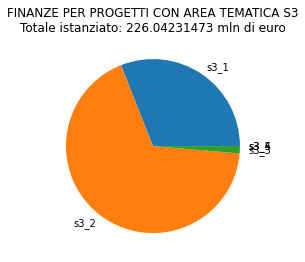

In [307]:
plt.title(f"FINANZE PER PROGETTI CON AREA TEMATICA S3\nTotale istanziato: {s3_tot*1E-6} mln di euro")
plt.pie(s3_tot_dict.values(), labels=s3_tot_dict.keys())
plt.show()

## Opzionale!
Salvataggio datasets.

**Nota**: Cambiare i path

In [56]:
main_path = "/home/hadoop_user/Scrivania/economia_app/"
if main_path: # Solo se non vuoto
    try:
        result_dataframe.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tot") # Dataset totale
        s3_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tematiche_s3")   # Dataset dimensioni tematiche s3
        ind4_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_industria_4.0")# Dataset industria 4.0   
    except Exception as e:
        print("C'e' stato un errore nel salvataggio: " + e)
else: print("Aggiungere il path")